In [32]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import yt.units as yu
from yt import physical_constants as phyc
import yt

yt.funcs.mylog.setLevel(50) # suppress log messages except for critical ones
sys.path.insert(0, '../../') # add tigradpy to python path
sys.path.insert(0, '../../pyathena') # add tigradpy to python path
import tigradpy as tp
import pyathena as pa
print tp.__all__

['add_fields', 'plt_multipanel', 'read_hst']


In [39]:
## Need to write a conveience unit object
units_override = dict(length_unit=(1., 'pc'),
                      time_unit=((yu.pc/(yu.km/yu.s)).in_units('Myr'), 'Myr'),
                      mass_unit=((1.4272*phyc.mass_hydrogen_cgs*
                                 (yu.pc/yu.cm)**3).in_units('Msun'), 'Msun'))

num = 1
datadir = '/scratch/gpfs/jk11/tigrad_pp/rad_8pc_pp_dmax1024_colli'
#datadir = '/home/jk11/athena-tigress/bin'
filename = os.path.join(datadir, 'rad_8pc_pp.{0:04d}.vtk'.format(num))

# the most recent yt spits out a strange warning message when dataset is loaded..
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    ds = yt.load(filename, units_override=units_override)
tp.add_fields(ds, IXN=3)

__Example x-z and xy slices and projections of $n_{\rm H}$, $x_n$, radiation density__

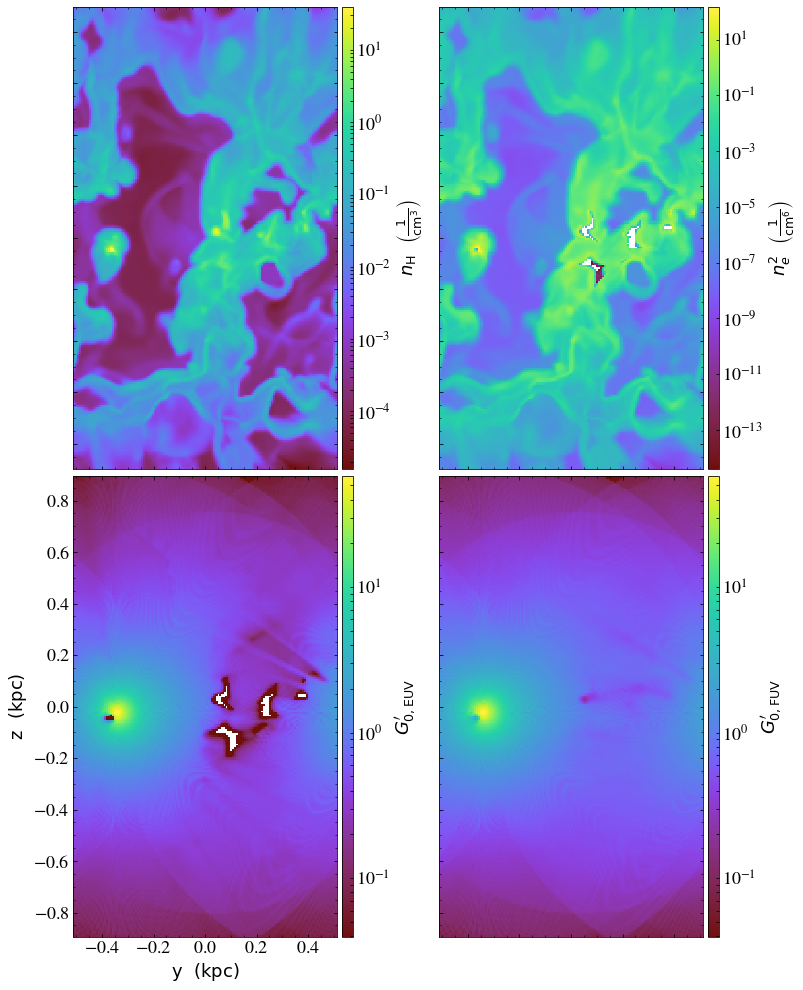

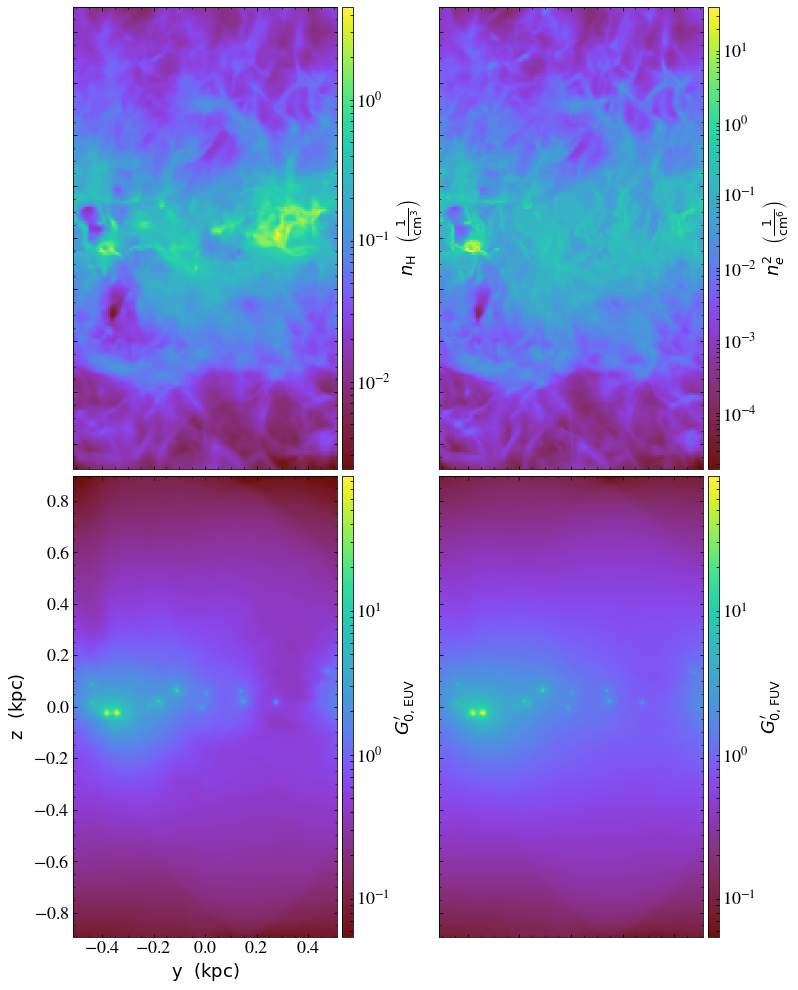

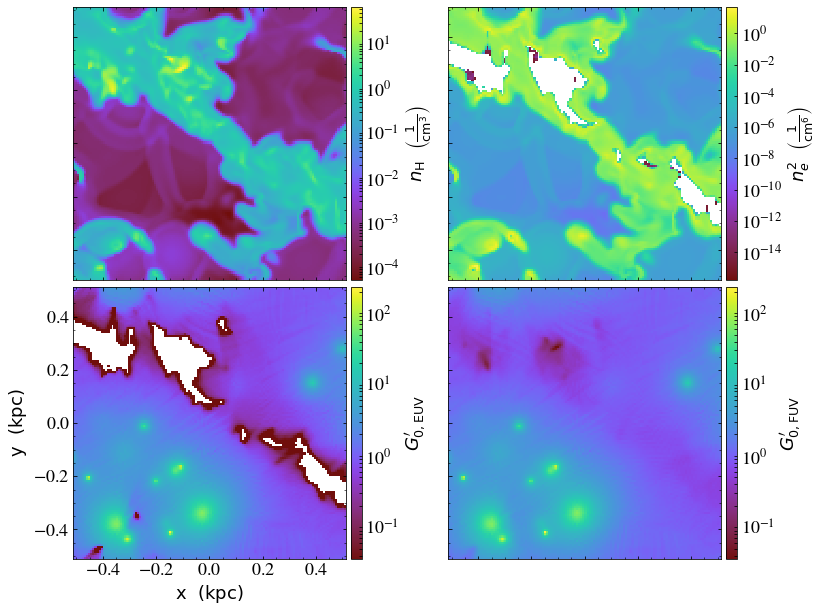

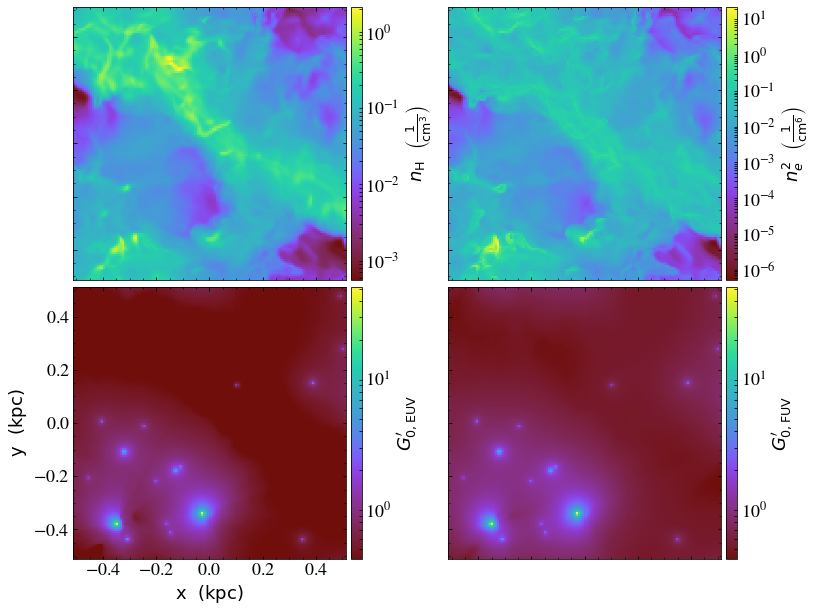

In [34]:
fields = ['nH', 'nesq', 'G0prime0', 'G0prime1']

sy = tp.plt_multipanel(ds, 'slice', 'x', fields=fields)
py = tp.plt_multipanel(ds, 'projection', 'x', fields=fields)
sz = tp.plt_multipanel(ds, 'slice', 'z', fields=fields)
pz = tp.plt_multipanel(ds, 'projection', 'z', fields=fields)

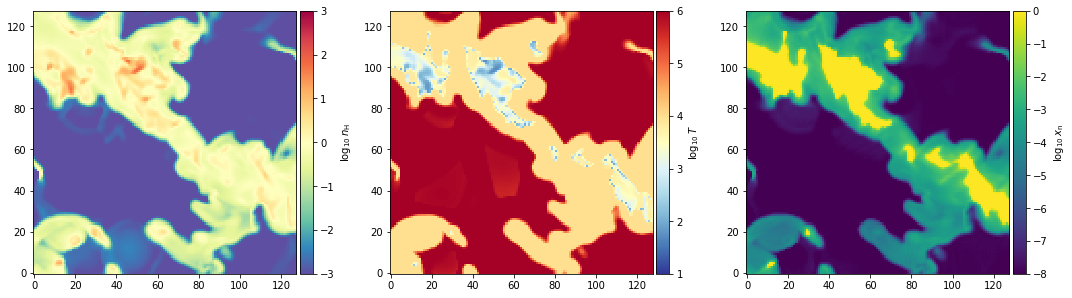

In [41]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
da = ds.all_data()
d = da['nH'].reshape(128,128,224)[:,:,112].v
T = da['Temperature'].reshape(128,128,224)[:,:,112].v
Tma = np.ma.masked_where(T > 1e8, T)
plt.sca(axes[0])
im0 = plt.imshow(np.log10(d).T, origin='lower', vmin=-3, vmax=3,
                 cmap='Spectral_r')
divider = make_axes_locatable(plt.gca())
cax0 = divider.append_axes('right', size='5%', pad=0.05)
cb0 = plt.colorbar(im0, cax=cax0)
cb0.set_label(r'$\log_{10}\,n_{\rm H}$')

plt.sca(axes[1])
im1 = plt.imshow(np.log10(Tma).T, origin='lower', vmin=1.0, vmax=6,
                 cmap='RdYlBu_r')
divider = make_axes_locatable(plt.gca())
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$\log_{10}\,T$')

plt.sca(axes[2])
xn = da['xn'].reshape(128,128,224)[:,:,112].v
im2 = plt.imshow(np.log10(xn).T, origin='lower', vmin=-8.0, vmax=0.0,
                 cmap='viridis')
divider = make_axes_locatable(plt.gca())
cax2 = divider.append_axes('right', size='5%', pad=0.05)
cb2 = plt.colorbar(im2, cax=cax2)
cb2.set_label(r'$\log_{10}\,x_{\rm n}$')

plt.tight_layout()

__Read original data__

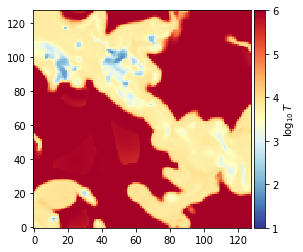

In [37]:
num = 200
datadir = '/tigress//jk11/tigrad_pp/rad_8pc'
#datadir = '/home/jk11/athena-tigress/bin'
filename = os.path.join(datadir, 'rad_8pc.{0:04d}.vtk'.format(num))

# # the most recent yt spits out a strange warning message when dataset is loaded..
# import warnings
# with warnings.catch_warnings():
#     warnings.simplefilter("ignore")
#     ds = yt.load(filename, units_override=units_override)

import pyathena as pa
ds = pa.AthenaDataSet(filename)
den = ds.read_all_data('density')
P = ds.read_all_data('pressure')
import astropy.constants as c
import astropy.units as u
unit=pa.set_units(muH=1.4271)
to_pok=(unit['pressure']/c.k_B).cgs.value
pok = P*to_pok
T1_new = pok/den/1.4272
T1 = ds.read_all_data('T1')
temp = pa.coolftn.get_temp(T1)
#denslice=d[icen[2],:,:]
Tslc = temp[112,:,:]
im1 = plt.imshow(np.log10(Tslc), origin='lower', vmin=1.0, vmax=6,
                 cmap='RdYlBu_r')
divider = make_axes_locatable(plt.gca())
cax1 = divider.append_axes('right', size='5%', pad=0.05)
cb1 = plt.colorbar(im1, cax=cax1)
cb1.set_label(r'$\log_{10}\,T$')


##### Compare original T and T after post-processing

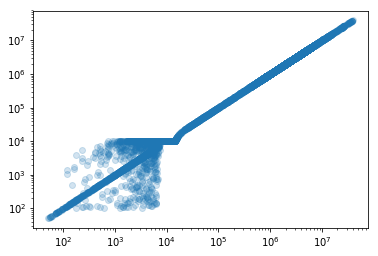

In [51]:
#plt.scatter(d.flatten(), Tma.flatten(), alpha=0.2)
plt.scatter(Tslc.T.flatten(), Tma.flatten(), alpha=0.2)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('')
#plt.xlim(1e-5,1e2)

In [35]:
num = 0
datadir = '/tigress/jk11/tigrad_pp/rad_8pc_pp_dmax1024_ionrad/'
filename = os.path.join(datadir, 'rad_8pc_pp.{0:04d}.vtk'.format(num))

ds = pa.AthenaDataSet(filename)
print ds.field_list

[u'rad_flux0', u'rad_flux1', u'density', u'rad_energy_density0', u'rad_energy_density1', u'specific_scalar1', u'specific_scalar0', u'specific_scalar3', u'specific_scalar2', u'pressure', u'velocity']


[-512.0, 512.0, -512.0, 512.0] [-512.0, 512.0, -896.0, 896.0] [-512.0, 512.0, -896.0, 896.0]


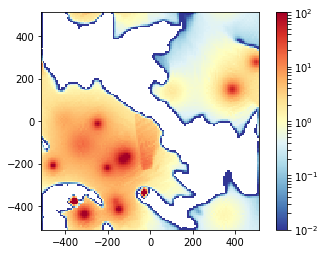

In [60]:
import matplotlib as mpl
d = ds.read_all_data('rad_energy_density0')
icen=ds.domain['Nx']/2
xmin=ds.domain['left_edge']
xmax=ds.domain['right_edge']
xyextent=[xmin[0],xmax[0],xmin[1],xmax[1]]
xzextent=[xmin[0],xmax[0],xmin[2],xmax[2]]
yzextent=[xmin[1],xmax[1],xmin[2],xmax[2]]
print xyextent,xzextent,yzextent

denslice=d[icen[2],:,:]
im=plt.imshow(denslice, norm=mpl.colors.LogNorm(),origin='lower')
im.set_extent(xyextent)
im.set_clim(1.e-2,1.e2)
im.set_cmap('RdYlBu_r')
plt.colorbar(im)

#This shows a slice of vertical velocity at y=Nx[1]/2
fig = plt.figure(figsize=(5, 5))
im=plt.imshow(vz[:,Nx[1]/2,:],origin='lower',cmap='bwr')
im.set_extent(xzextent)
plt.colorbar(im)

In [4]:
def _Temperature(field, data):
        return data["pressure"]/(4.0*np.pi*yu.sr)*phyc.clight
    
ds.add_field(("athena","Temperature"), sampling_type="cell",
             function=_Temperature, units="K", take_log=True,
             display_name=r'$T\;[{\rm K}]$')

rad_8pc_pp.0003

(array([3.248902e+06, 2.884860e+05, 4.808900e+04, 3.898600e+04,
        2.206600e+04, 1.278200e+04, 7.848000e+03, 2.252000e+03,
        5.140000e+02, 9.100000e+01]),
 array([2.20824275e+00, 2.81996510e+06, 5.63992798e+06, 8.45989087e+06,
        1.12798538e+07, 1.40998166e+07, 1.69197795e+07, 1.97397424e+07,
        2.25597053e+07, 2.53796682e+07, 2.81996311e+07]),
 <a list of 10 Patch objects>)

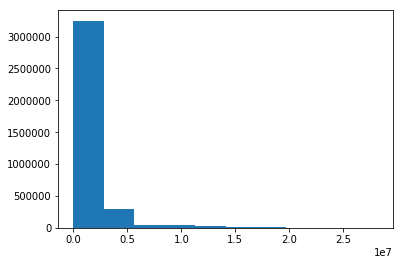

In [16]:
import yt.units as yu
from yt import physical_constants as phyc

muH = 1.4272
lunit = yu.pc
tunit = yu.pc/(yu.km/yu.s)
munit = (muH*phyc.mass_hydrogen_cgs*(yu.pc/yu.cm)**3).in_units('Msun')
vunit = lunit/tunit
Eunit = munit/(lunit*tunit**2)       # energy density
Funit = (Eunit*lunit/tunit).in_cgs() # flux

da = ds.all_data()

(da['pressure']/((1.1*da['nH'] + da['nelec'])*phyc.kb)).v

In [17]:
da['pressure']

YTArray([1.78764202e-14, 1.73696326e-14, 1.73791294e-14, ...,
         1.18748770e-13, 1.15014951e-13, 1.14037341e-13]) dyne/cm**2

In [8]:
phyc.kb

1.3806488e-16 erg/K